## Must do

1. exclude those who have a date lost to follow-up below May 2017 based on data-field 191 (done in extract features)

In [1]:
from IPython.display import display, HTML
import pandas as pd
from lxml import etree
import time
import re
import matplotlib.pyplot as plt
import random
import codecs
import dask.dataframe as dd
import dask.array as da
import numpy as np
import pickle
from datetime import datetime





from bs4 import BeautifulSoup
import requests
from lxml import etree
import pandas as pd
import unicodedata

In [2]:
#PATH_data=r"/home/workspace/datasets/ukbiobank/ukbiobank_yajiez/dataset/ukb26438.csv"
#PATH_dict=r"/home/workspace/datasets/ukbiobank/ukbiobank_yajiez/dataset/ukb26438.html"

PATH_data=r"/home/workspace/datasets/ukbiobank/biobank_milad_34943/ukb34943.csv"
PATH_dict=r"/home/mo/ukb34943.html"

# Read the field ID summary html file

In [3]:
def fielID_to_ctgry(page):
    "The function produces a dictionary from for a given URL above mapping field\
    IDs column[0] to an array with the first element being the description of the\
    field ID and the second element being its corresponding category "
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find(lambda tag: tag.name=='table') 
    rows = table.findAll(lambda tag: tag.name=='tr')
    
    fieldID_to_ctgry_dict=dict()
    for tr in rows:
        td = tr.find_all('td')
        if len(td)>3:
            td.pop()
        row = [tr.text for tr in td]
        try:
            fieldID_to_ctgry_dict[row[0]]=[row[1],unicodedata.normalize("NFKD", row[2]).rstrip()]
        except:
            pass
    return fieldID_to_ctgry_dict


def summarise(PATH_dict):
    """
    takes the dictionary file and produces 3 outputs
    A.UDI_to_dscrpt: a dictionary mapping each UDI to #1: column 
                                                            2: count 
                                                            3: type   
                                                            4: description 
                                                            5: num_instances 
                                                            6: num_Measurements       

    """
    
    html_file = open(PATH_dict)
    html_content = html_file.read()
    parsed_html = etree.HTML(html_content)
    html_tables = parsed_html.findall("body/table")
    
    #This is the main table that contains the field ID descriptions
    pd_code_to_desc=pd.read_html(etree.tostring(html_tables[1]))[0]
    
    #Extract all unique field IDs
    
    tic = time.perf_counter()
    UDI_to_dscrpt=dict()

    for i in range(1,pd_code_to_desc.shape[0]):
        code_name,inst_num=pd_code_to_desc.iloc[i][1].split('-')
        try:
            UDI_to_dscrpt[code_name]
            inst,num=inst_num.split('.')
            UDI_to_dscrpt[code_name][4:6]=[int(inst), int(num)]
        except:
            UDI_to_dscrpt[code_name]=[pd_code_to_desc.iloc[i][0],
                                                pd_code_to_desc.iloc[i][2],
                                                   pd_code_to_desc.iloc[i][3],
                                                   pd_code_to_desc.iloc[i][4],
                                                   0,
                                                   0]#1: column 2: count 3: type   4: description 5: instances 6: num_Measurements       

    toc = time.perf_counter()   
    print('Time elapsed for extracting unique field IDs: '+str(toc-tic))
    print('The number of unique field IDs: '+str(len(UDI_to_dscrpt)))
  
    return UDI_to_dscrpt


def get_categories(UID_to_dscrpt,fieldID_to_ctgry_dict):
        """The produces a dictionary with the categories present in the dataset as the keys
        and values being an array of field IDs for each category in the dataset as peresent in UID_to_dscrpt
        field_ID_no_category shows the list of field IDs that were present in the dataset (UID_to_dscrpt) 
        but were not found in the URLS and therefore have not categories"""
        categories=dict()
        fieldID_no_category=dict() #a dictionary containing field IDs that do not appear in the URLs and therefore have no categories
        for fieldID in UID_to_dscrpt.keys():
            try:
                categories[fieldID_to_ctgry_dict[fieldID][1]]=[]
            except:
                print('Field ID '+str(fieldID)+' did not exist in the dictionary!')
                print(' ** \t '+UID_to_dscrpt[fieldID][3]+' ')
                fieldID_no_category[fieldID]=UID_to_dscrpt[fieldID][3]

        for fieldID in UID_to_dscrpt.keys():
            try:
                categories[fieldID_to_ctgry_dict[fieldID][1]].append(fieldID+': '+UID_to_dscrpt[fieldID][3])
            except:
                pass
        return categories,fieldID_no_category

def findWholeWord(w):
    #\b({0})\b'
    return re.compile(r'({0})'.format(w), flags=re.IGNORECASE).search 


def search_description(word,UDI_to_dscrpt):
    """
    This function searches the description element of the UDI_to_dscrpt dictionary for a word
    """
    for key in UDI_to_dscrpt.keys():
        if findWholeWord(word)(UDI_to_dscrpt[key][3]):
            print('Field ID: '+key+' _ '+UDI_to_dscrpt[key][3]+'\n')

In [4]:
URLS=['http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=11',
     'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=21',
     'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=22' ,
      'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=31' ,
      'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=41' ,
      'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=51' ,
      'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=61' ,
      'http://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=0&vt=101',
      'https://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=20&vt=-1',
      'https://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=10&vt=-1',
      'https://biobank.ctsu.ox.ac.uk/crystal/list.cgi?it=30&vt=-1']

In [5]:
fieldID_to_ctgry_dict=dict()
#compile the dictionary for mapping fieldIDs to categories form the URLs
for url in URLS:
    page = requests.get(url)
    fieldID_to_ctgry_dict={**fieldID_to_ctgry_dict,**fielID_to_ctgry(page)}
print('fieldID_to_ctgry_dict compiled from URLS with '+str(len(fieldID_to_ctgry_dict.keys()))+'field IDs')

#get a list unique field IDs in the html file with their descriptions and other descriptive stats
UID_to_dscrpt=summarise(PATH_dict)   

#map filed IDs in the data to categories and show as dict
categories,fieldID_no_category=get_categories(UID_to_dscrpt,fieldID_to_ctgry_dict)

word='diagnoses'
search_description(word,UID_to_dscrpt)

fieldID_to_ctgry_dict compiled from URLS with 7810field IDs
Time elapsed for extracting unique field IDs: 2.5403568129986525
The number of unique field IDs: 1827
Field ID 3 did not exist in the dictionary!
 ** 	 Verbal interview duration 
Field ID 4 did not exist in the dictionary!
 ** 	 Biometrics duration 
Field ID 5 did not exist in the dictionary!
 ** 	 Sample collection duration 
Field ID 6 did not exist in the dictionary!
 ** 	 Conclusion duration 
Field ID 36 did not exist in the dictionary!
 ** 	 Blood pressure device ID 
Field ID 37 did not exist in the dictionary!
 ** 	 Blood pressure manual sphygmomanometer device ID 
Field ID 38 did not exist in the dictionary!
 ** 	 Hand grip dynamometer device ID 
Field ID 39 did not exist in the dictionary!
 ** 	 Height measure device ID 
Field ID 40 did not exist in the dictionary!
 ** 	 Manual scales device ID 
Field ID 41 did not exist in the dictionary!
 ** 	 Seating box device ID 
Field ID 43 did not exist in the dictionary!
 ** 	 I

In [6]:
for category in categories.keys():
    print('Category: '+category)
    for fieldID in categories[category]:
        print('\t \t '+fieldID)

Category: Body size measures
	 	 21: Weight methodUses data-coding 100261
	 	 48: Waist circumference
	 	 49: Hip circumference
	 	 50: Standing height
	 	 51: Seated height
	 	 3077: Seating box heightUses data-coding 100262
	 	 3160: Weight, manual entry
	 	 12143: Weight (pre-imaging)
	 	 12144: Height
	 	 20015: Sitting height
	 	 20041: Reason for skipping weightUses data-coding 47
	 	 20045: Reason for skipping waistUses data-coding 47
	 	 20046: Reason for skipping hip measurementUses data-coding 47
	 	 20047: Reason for skipping standing heightUses data-coding 47
	 	 20048: Reason for skipping sitting heightUses data-coding 47
	 	 21001: Body mass index (BMI)
	 	 21002: Weight
Category: Baseline characteristics
	 	 31: SexUses data-coding 9
	 	 34: Year of birth
	 	 52: Month of birthUses data-coding 8
	 	 189: Townsend deprivation index at recruitment
	 	 21022: Age at recruitment
Category: Hand grip strength
	 	 46: Hand grip strength (left)
	 	 47: Hand grip strength (right)

# 2. Read data as pd for correctness check

## 2.1 read datafields by categories in numpy

In [7]:
def save_obj(obj, name ):
    with open('obj_'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj_' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
tic = time.perf_counter()
column_names = pd.read_csv(PATH_data, dtype='unicode',nrows=1).columns
df = pd.read_csv(PATH_data,dtype='unicode',engine='python')
#df=next(df)
toc = time.perf_counter()
print('Time to read the data: '+str(toc-tic))
df

Time to read the data: 2740.4641248565167


,eid,3-0.0,3-1.0,3-2.0,4-0.0,4-1.0,4-2.0,5-0.0,5-1.0,5-2.0,...,105030-1.0,105030-2.0,105030-3.0,105030-4.0,110002-1.0,110002-2.0,110002-3.0,110002-4.0,110008-1.0,110008-2.0
0,2295908,198,NaN,NaN,425,NaN,NaN,171,NaN,NaN,...,2011-03-09T22:54:02,NaN,2011-11-11T23:20:00,2012-05-16T23:02:31,2011-03-09,2011-07-24,2011-11-10,2012-05-14,2012-11-04,NaN
1,3379474,311,380,308,716,589,379,276,200,212,...,NaN,NaN,NaN,NaN,2011-03-31,2011-08-30,2011-11-25,2012-05-29,2012-11-11,NaN
2,3589840,315,NaN,588,659,NaN,597,226,NaN,262,...,NaN,NaN,2011-10-20T20:26:18,NaN,2011-02-19,2011-06-29,2011-10-16,2012-04-19,NaN,NaN
3,5756616,266,NaN,NaN,620,NaN,NaN,122,NaN,NaN,...,NaN,NaN,NaN,NaN,2011-02-26,2011-07-06,2011-10-23,2012-04-26,NaN,NaN
4,4901805,894,NaN,NaN,462,NaN,NaN,212,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502522,4184562,354,NaN,NaN,701,NaN,NaN,269,NaN,NaN,...,NaN,NaN,NaN,NaN,2011-04-03,NaN,NaN,NaN,NaN,NaN
502523,4678132,367,NaN,NaN,643,NaN,NaN,218,NaN,NaN,...,2011-02-20T19:26:01,NaN,2011-10-17T17:23:50,2012-04-20T16:20:13,2011-02-20,2011-06-30,2011-10-17,2012-04-20,NaN,NaN
502524,2350842,419,NaN,NaN,666,NaN,NaN,247,NaN,NaN,...,NaN,2011-07-21T09:36:03,NaN,NaN,2011-03-06,2011-07-21,2011-11-07,2012-05-11,2012-09-23,NaN
502525,5353909,601,NaN,NaN,524,NaN,NaN,214,NaN,NaN,...,NaN,NaN,NaN,NaN,2011-04-11,2011-08-20,2011-12-06,2012-06-09,2012-07-20,NaN


# 3 Extract outcomes

## 3.1 41270 & 41280 (primary and secondary)
For the time being I'm only using the myocardia infraction, the date of which I have access to through the data field 42000, later these will have to be extracted from 

In [9]:
def preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config):
    class CustomError(Exception):
        pass
    new_UID_to_dscrpt=dict()
    newdf=pd.DataFrame()
    #run through each category go through selected_categories and determine what field IDs to select
    newdf_col_cnt=0
    for cat in selected_categories.keys():
        selection_type=selected_categories[cat][0]
        listed_fieldIDs=set(selected_categories[cat][1:])
        accepted_values=('include','exclude','include all','exclude all')
        if selection_type not in accepted_values:
            raise ValueError('The first element of the selected_categories dictionary array for the category "{}" needs\
            to be one of the values below \n{}.\nThe input value is "{}".'.format(cat,accepted_values,selection_type))    
        
        #run through each category go through selected_categories and determine what field IDs to select
        all_fieldIDs={fieldID.split(':')[0] for fieldID in categories[cat]}
        if selection_type=='include all':
            selected_fieldIDs=all_fieldIDs
        elif selection_type=='exclude all':
            selected_fieldIDs=[]
        elif selection_type=='include':
            if listed_fieldIDs.issubset(all_fieldIDs):
                selected_fieldIDs=listed_fieldIDs
            else:
                raise ValueError('The field IDs selected to be included are not valid.')
        elif selection_type=='exclude':
            if listed_fieldIDs.issubset(all_fieldIDs):
                selected_fieldIDs=all_fieldIDs.difference(listed_fieldIDs)
            else: 
                raise ValueError('The field IDs selected to be excluded are not valid.')
        else:
            raise CustomError('This has happened due to a bug, investigate!')

        print('From the category {} the following where selected: \n \t {}'.format(cat,selected_fieldIDs))
        for FID in selected_fieldIDs:
            print('\t FID {}:  {}'.format(FID,UID_to_dscrpt[FID][3]))

        #
        for FID in selected_fieldIDs:
            newdf=pd.concat([newdf,df.iloc[:,UID_to_dscrpt[FID][0]:UID_to_dscrpt[FID][0]+(UID_to_dscrpt[FID][4]+1)*(UID_to_dscrpt[FID][5]+1)].astype(process_config[FID]['type'])],axis=1)
            newdf_col_cnt+=1
    #display(HTML(newdf.head().to_html()))
    return newdf

In [18]:
#temp delete ASAP 190
"""
word='follow'
print(search_description(word,UID_to_dscrpt))
print(fieldID_to_ctgry_dict['190'])
categories['Ongoing characteristics']


selected_categories={'Ongoing characteristics':['include','190']}
process_config={'190':{'type':'string'}}
df_temp=preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config)

df_temp.to_csv("lost_follow_up.csv")
"""

Field ID: 190 _ Reason lost to follow-upUses data-coding 1965

Field ID: 191 _ Date lost to follow-up

Field ID: 20086 _ Type of special diet followedUses data-coding 76

Field ID: 20554 _ Actions taken following self-harmUses data-coding 1423

None
['Reason lost to follow-up', 'Ongoing characteristics']
From the category Ongoing characteristics the following where selected: 
 	 {'190'}
	 FID 190:  Reason lost to follow-upUses data-coding 1965


In [10]:
word='ICD'
print(search_description(word,UID_to_dscrpt))
print(fieldID_to_ctgry_dict['41270'])
categories['Summary Diagnoses']

Field ID: 40001 _ Underlying (primary) cause of death: ICD10Uses data-coding 19

Field ID: 40002 _ Contributory (secondary) causes of death: ICD10Uses data-coding 19

Field ID: 40006 _ Type of cancer: ICD10Uses data-coding 19

Field ID: 40013 _ Type of cancer: ICD9Uses data-coding 87

Field ID: 41201 _ External causes - ICD10Uses data-coding 240

Field ID: 41202 _ Diagnoses - main ICD10Uses data-coding 240

Field ID: 41203 _ Diagnoses - main ICD9Uses data-coding 240

Field ID: 41204 _ Diagnoses - secondary ICD10Uses data-coding 240

Field ID: 41205 _ Diagnoses - secondary ICD9Uses data-coding 240

Field ID: 41262 _ Date of first in-patient diagnosis - main ICD10

Field ID: 41263 _ Date of first in-patient diagnosis - main ICD9

Field ID: 41270 _ Diagnoses - ICD10Uses data-coding 259

Field ID: 41271 _ Diagnoses - ICD9Uses data-coding 259

Field ID: 41280 _ Date of first in-patient diagnosis - ICD10

Field ID: 41281 _ Date of first in-patient diagnosis - ICD9

None
['Diagnoses - ICD10',

['41201: External causes - ICD10Uses data-coding 240',
 '41202: Diagnoses - main ICD10Uses data-coding 240',
 '41203: Diagnoses - main ICD9Uses data-coding 240',
 '41204: Diagnoses - secondary ICD10Uses data-coding 240',
 '41205: Diagnoses - secondary ICD9Uses data-coding 240',
 '41262: Date of first in-patient diagnosis - main ICD10',
 '41263: Date of first in-patient diagnosis - main ICD9',
 '41270: Diagnoses - ICD10Uses data-coding 259',
 '41271: Diagnoses - ICD9Uses data-coding 259',
 '41280: Date of first in-patient diagnosis - ICD10',
 '41281: Date of first in-patient diagnosis - ICD9']

In [19]:
outcomes=['I20-I25 Ischaemic heart diseases',
'I30-I52 Other forms of heart disease',
'I70-I79 Diseases of arteries, arterioles and capillaries'
'I20.0 Unstable angina',
'I20.9 Angina pectoris, unspecified',
'I21 Acute myocardial infarction',
'I25.1 Atherosclerotic heart disease',
'I48 Atrial fibrillation and flutter', 
'I50 Heart failure']

outcomes=["I10"]

In [20]:
selected_categories={'Summary Diagnoses':['include','41270']}
process_config={'41270':{'type':'string'}}

df_temp=preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config)


selected_categories={'Summary Diagnoses':['include','41280']}
process_config={'41280':{'type':'string'}}
df_temp_date=preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config)

selected_categories1={fieldID_to_ctgry_dict['53'][1]:['include','53']}
process_config1={'53':{'type':'string'}}

df_date_assessment=pd.to_datetime(preprocess(selected_categories1,categories,
                                             UID_to_dscrpt,df,process_config1)['53-0.0'],format='%Y-%m-%d').to_frame()

#Outcomes
"""
I20_25= ['I'+str(i) for i in range(20,26)]
I30_52=['I'+str(i) for i in range(30,53)]
I70_79=['I'+str(i) for i in range(70,80)]
outcomes_list=I20_25+I30_52+I70_79
"""
outcomes_list=outcomes

#find the bool_indx when one of the outcomes is found in df_temp
cols_dict={df_temp.columns.values[i]:df_temp_date.columns.values[i] for i in range(df_temp.shape[1])}
bool_indxs=df_temp.apply(lambda col: col.str.contains('|'.join(outcomes_list), na=False), axis=1)
#the corresponding bool indxing df for the dates dataframe
bool_indxs_date=bool_indxs.rename(columns=cols_dict)
df_temp_date=df_temp_date[bool_indxs_date].apply(pd.to_datetime)

the_earliest_outcome_diagnosis=df_temp_date.min(axis=1)# the first occurance of the disease(any of the ones specified in outcomes)

From the category Summary Diagnoses the following where selected: 
 	 {'41270'}
	 FID 41270:  Diagnoses - ICD10Uses data-coding 259
From the category Summary Diagnoses the following where selected: 
 	 {'41280'}
	 FID 41280:  Date of first in-patient diagnosis - ICD10
From the category Reception the following where selected: 
 	 {'53'}
	 FID 53:  Date of attending assessment centre


In [21]:
newdf=pd.DataFrame(index=df_temp.index,columns=['outcome_months','Exclude_outcomes','outcomes'])
newdf.loc[the_earliest_outcome_diagnosis<df_date_assessment['53-0.0'],'Exclude_outcomes']=1

newdf.loc[the_earliest_outcome_diagnosis>=df_date_assessment['53-0.0'],'outcomes']=1

newdf['outcome_months']=the_earliest_outcome_diagnosis.sub(df_date_assessment['53-0.0'])
newdf['outcome_months']=newdf['outcome_months']/np.timedelta64(1, 'M')

#replace MI_months nans with the duration of time between may 2017 and date of attending the assessment centre
indx=newdf.index[newdf['outcome_months'].isna()]
newdf.loc[indx,'outcome_months']=(datetime(2017,5,1)-df_date_assessment['53-0.0'])/np.timedelta64(1, 'M')
newdf.fillna(0,inplace=True)

In [22]:
selected_outcome_categories_tidy={'CVDs':['outcomes','outcome_months']}
selected_outcome_categories_tidy_columns={'outcomes':{"col_name":['outcome'],"type":"binary"},
                                         'outcome_months':{"col_name":['outcome_months'],"type":"int"}}
selected_outcome_categories_exclusions=["Exclude_outcomes"]

## 3.2 40000 40001 & 40002 (death registry) 

In [23]:
word='death'
print(search_description(word,UID_to_dscrpt))
print(fieldID_to_ctgry_dict['40002'])
categories['Death register']

Field ID: 1807 _ Father's age at deathUses data-coding 100435

Field ID: 3526 _ Mother's age at deathUses data-coding 100360

Field ID: 4501 _ Non-accidental death in close genetic familyUses data-coding 100259

Field ID: 20437 _ Thoughts of death during worst depressionUses data-coding 505

Field ID: 20530 _ Witnessed sudden violent deathUses data-coding 533

Field ID: 40000 _ Date of death

Field ID: 40001 _ Underlying (primary) cause of death: ICD10Uses data-coding 19

Field ID: 40002 _ Contributory (secondary) causes of death: ICD10Uses data-coding 19

Field ID: 40007 _ Age at death

Field ID: 40010 _ Description of cause of death

Field ID: 40018 _ Death record formatUses data-coding 261

Field ID: 40020 _ Death record originUses data-coding 1970

None
['Contributory (secondary) causes of death: ICD10', 'Death register']


['40000: Date of death',
 '40001: Underlying (primary) cause of death: ICD10Uses data-coding 19',
 '40002: Contributory (secondary) causes of death: ICD10Uses data-coding 19',
 '40007: Age at death',
 '40010: Description of cause of death',
 '40018: Death record formatUses data-coding 261',
 '40020: Death record originUses data-coding 1970']

In [19]:
selected_categories={'Death register':['include','40001','40002']}
process_config={'40001':{'type':'string'},'40002':{'type':'string'}}

df_temp=preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config)

selected_categories={'Death register':['include','40000']}
process_config={'40000':{'type':'string'}}
df_date_death=preprocess(selected_categories,categories,UID_to_dscrpt,df,process_config)['40000-0.0'].apply(pd.to_datetime)

From the category Death register the following where selected: 
 	 {'40001', '40002'}
	 FID 40001:  Underlying (primary) cause of death: ICD10Uses data-coding 19
	 FID 40002:  Contributory (secondary) causes of death: ICD10Uses data-coding 19
From the category Death register the following where selected: 
 	 {'40000'}
	 FID 40000:  Date of death


# Causes of death

In [76]:
causes_of_death=df_temp.loc[df_temp.notnull().any(axis=1)]
all_causes_of_death=[]
for indx in causes_of_death.index:
    if indx%10==0:
        pcauses_of_death=causes_of_death.loc[indx]
        all_causes_of_death=all_causes_of_death+list(pcauses_of_death[pcauses_of_death.notnull()].values)

In [153]:
unique, counts = np.unique(all_causes_of_death, return_counts=True) 
sum_dict=dict(zip(unique, counts))
sum_death=pd.DataFrame(sum_dict.items()).sort_values(1,ascending=True)

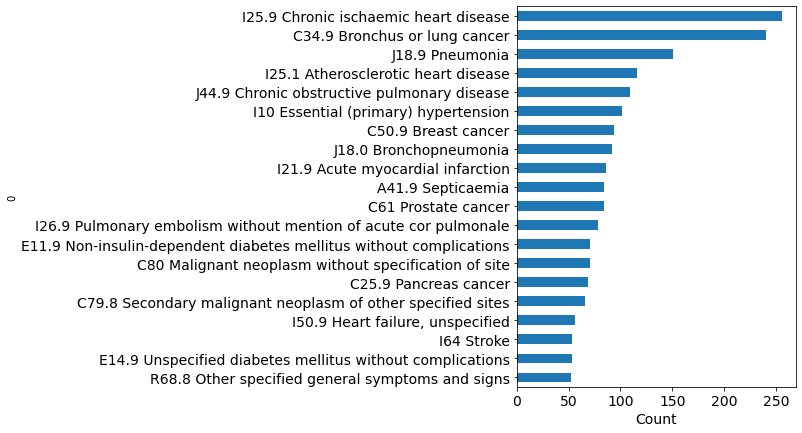

In [154]:
indexs=["I25.9 Chronic ischaemic heart disease","C34.9 Bronchus or lung cancer","J18.9 Pneumonia",
        "I25.1 Atherosclerotic heart disease","J44.9 Chronic obstructive pulmonary disease","I10 Essential (primary) hypertension",
       "C50.9 Breast cancer","J18.0 Bronchopneumonia","I21.9 Acute myocardial infarction",
       "A41.9 Septicaemia","C61 Prostate cancer","I26.9 Pulmonary embolism without mention of acute cor pulmonale",
       "E11.9 Non-insulin-dependent diabetes mellitus without complications","C80 Malignant neoplasm without specification of site","C25.9 Pancreas cancer",
       "C79.8 Secondary malignant neoplasm of other specified sites","I50.9 Heart failure, unspecified","I64 Stroke",
       "E14.9 Unspecified diabetes mellitus without complications","R68.8 Other specified general symptoms and signs"]
indexs.reverse()
sum_death1=sum_death.iloc[-20:].copy()
sum_death1[0]=indexs
fig,ax=plt.subplots(figsize=(5,7))
plt.rcParams.update({'font.size': 12})
#ax1.legend(loc=2,fontsize=20)
ax.set_ylabel(indexs,fontdict={'fontsize':10})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Count",fontdict={'fontsize':14})

sum_death1.plot.barh(x=0,y=1,ax=ax,legend=False)
plt.savefig("primarycausesofdeath")


In [25]:
bool_indxs=df_temp.apply(lambda col: col.str.contains('|'.join(outcomes_list), na=False), axis=1)
df_date_death_outcome=df_date_death[bool_indxs.any(axis=1)] #this is death due to outcomes of interest (CVDs defined above)
#find indices (patients) in newdf where death has been to do the outcomes (df_date_death_outcome.index) but have not had previous diagnoses, 
#i.e. outcomes=0 and exclude_outcomes=0
indxs_to_be_updated=(newdf.iloc[df_date_death_outcome.index]['Exclude_outcomes']==0) & \
(newdf.iloc[df_date_death_outcome.index]['outcomes']==0)

indxs_to_be_updated=indxs_to_be_updated[indxs_to_be_updated] #This contains only the true values (those that need to be updated)


#now update the outcomes, and outcome_months of these indices
newdf.loc[indxs_to_be_updated.index]['outcomes']=1
newdf.loc[indxs_to_be_updated.index]['outcome_months']=df_date_death_outcome.loc[indxs_to_be_updated.index].sub(df_date_assessment.loc[indxs_to_be_updated.index,'53-0.0'])/np.timedelta64(1, 'M')

newdf['death']=df_date_death


In [26]:
word='follow'
print(search_description(word,UID_to_dscrpt))
print(fieldID_to_ctgry_dict['40002'])
categories['Death register']

Field ID: 190 _ Reason lost to follow-upUses data-coding 1965

Field ID: 191 _ Date lost to follow-up

Field ID: 20086 _ Type of special diet followedUses data-coding 76

Field ID: 20554 _ Actions taken following self-harmUses data-coding 1423

None
['Contributory (secondary) causes of death: ICD10', 'Death register']


['40000: Date of death',
 '40001: Underlying (primary) cause of death: ICD10Uses data-coding 19',
 '40002: Contributory (secondary) causes of death: ICD10Uses data-coding 19',
 '40007: Age at death',
 '40010: Description of cause of death',
 '40018: Death record formatUses data-coding 261',
 '40020: Death record originUses data-coding 1970']

In [27]:
import pickle
newdf.to_csv(r'tidy_data_tiles/OutcomesHT.csv')

save_obj(selected_outcome_categories_tidy,'selected_outcome_categories_tidyHT')
save_obj(selected_outcome_categories_tidy_columns,'selected_outcome_categories_tidy_columnsHT')
save_obj(selected_outcome_categories_exclusions,'selected_outcome_categories_exclusionsHT')